In [5]:
import scanpy as scp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy as sp
import pandas as pd
import umap

import sys
sys.path.append('../../')
from scCustomFunctions import *
from parameters import *

import warnings
warnings.filterwarnings('ignore')

In [9]:
a = scp.read("data/qc.h5ad")
scp.pp.log1p(a) #Logarithmize data
a = a[a.obs["imputed"]==False]

# Compute corrections

We compute batch corrections using two different algorithms

1. Harmony
2. Fast MNN (MNN algorithm used on the first 50 pcs)

**Results:** Raw data shows that it is required to batch correct the datasets. Fast MNN has not been able to integrate all the datasets. On the other hand, Harmony has manage to do it with an appropiate mixing.

... storing 'sample' as categorical
... storing 'stage' as categorical
2022-03-04 10:54:48,393 - harmonypy - INFO - Iteration 1 of 10
2022-03-04 10:54:48,750 - harmonypy - INFO - Iteration 2 of 10
2022-03-04 10:54:49,106 - harmonypy - INFO - Iteration 3 of 10
2022-03-04 10:54:49,480 - harmonypy - INFO - Iteration 4 of 10
2022-03-04 10:54:49,849 - harmonypy - INFO - Iteration 5 of 10
2022-03-04 10:54:50,098 - harmonypy - INFO - Iteration 6 of 10
2022-03-04 10:54:50,302 - harmonypy - INFO - Iteration 7 of 10
2022-03-04 10:54:50,458 - harmonypy - INFO - Iteration 8 of 10
2022-03-04 10:54:50,596 - harmonypy - INFO - Iteration 9 of 10
2022-03-04 10:54:50,874 - harmonypy - INFO - Iteration 10 of 10
2022-03-04 10:54:50,995 - harmonypy - INFO - Converged after 10 iterations
... storing 'sample' as categorical
... storing 'stage' as categorical
2022-03-04 10:54:59,381 - harmonypy - INFO - Iteration 1 of 10
2022-03-04 10:54:59,549 - harmonypy - INFO - Iteration 2 of 10
2022-03-04 10:54:59,633 - 

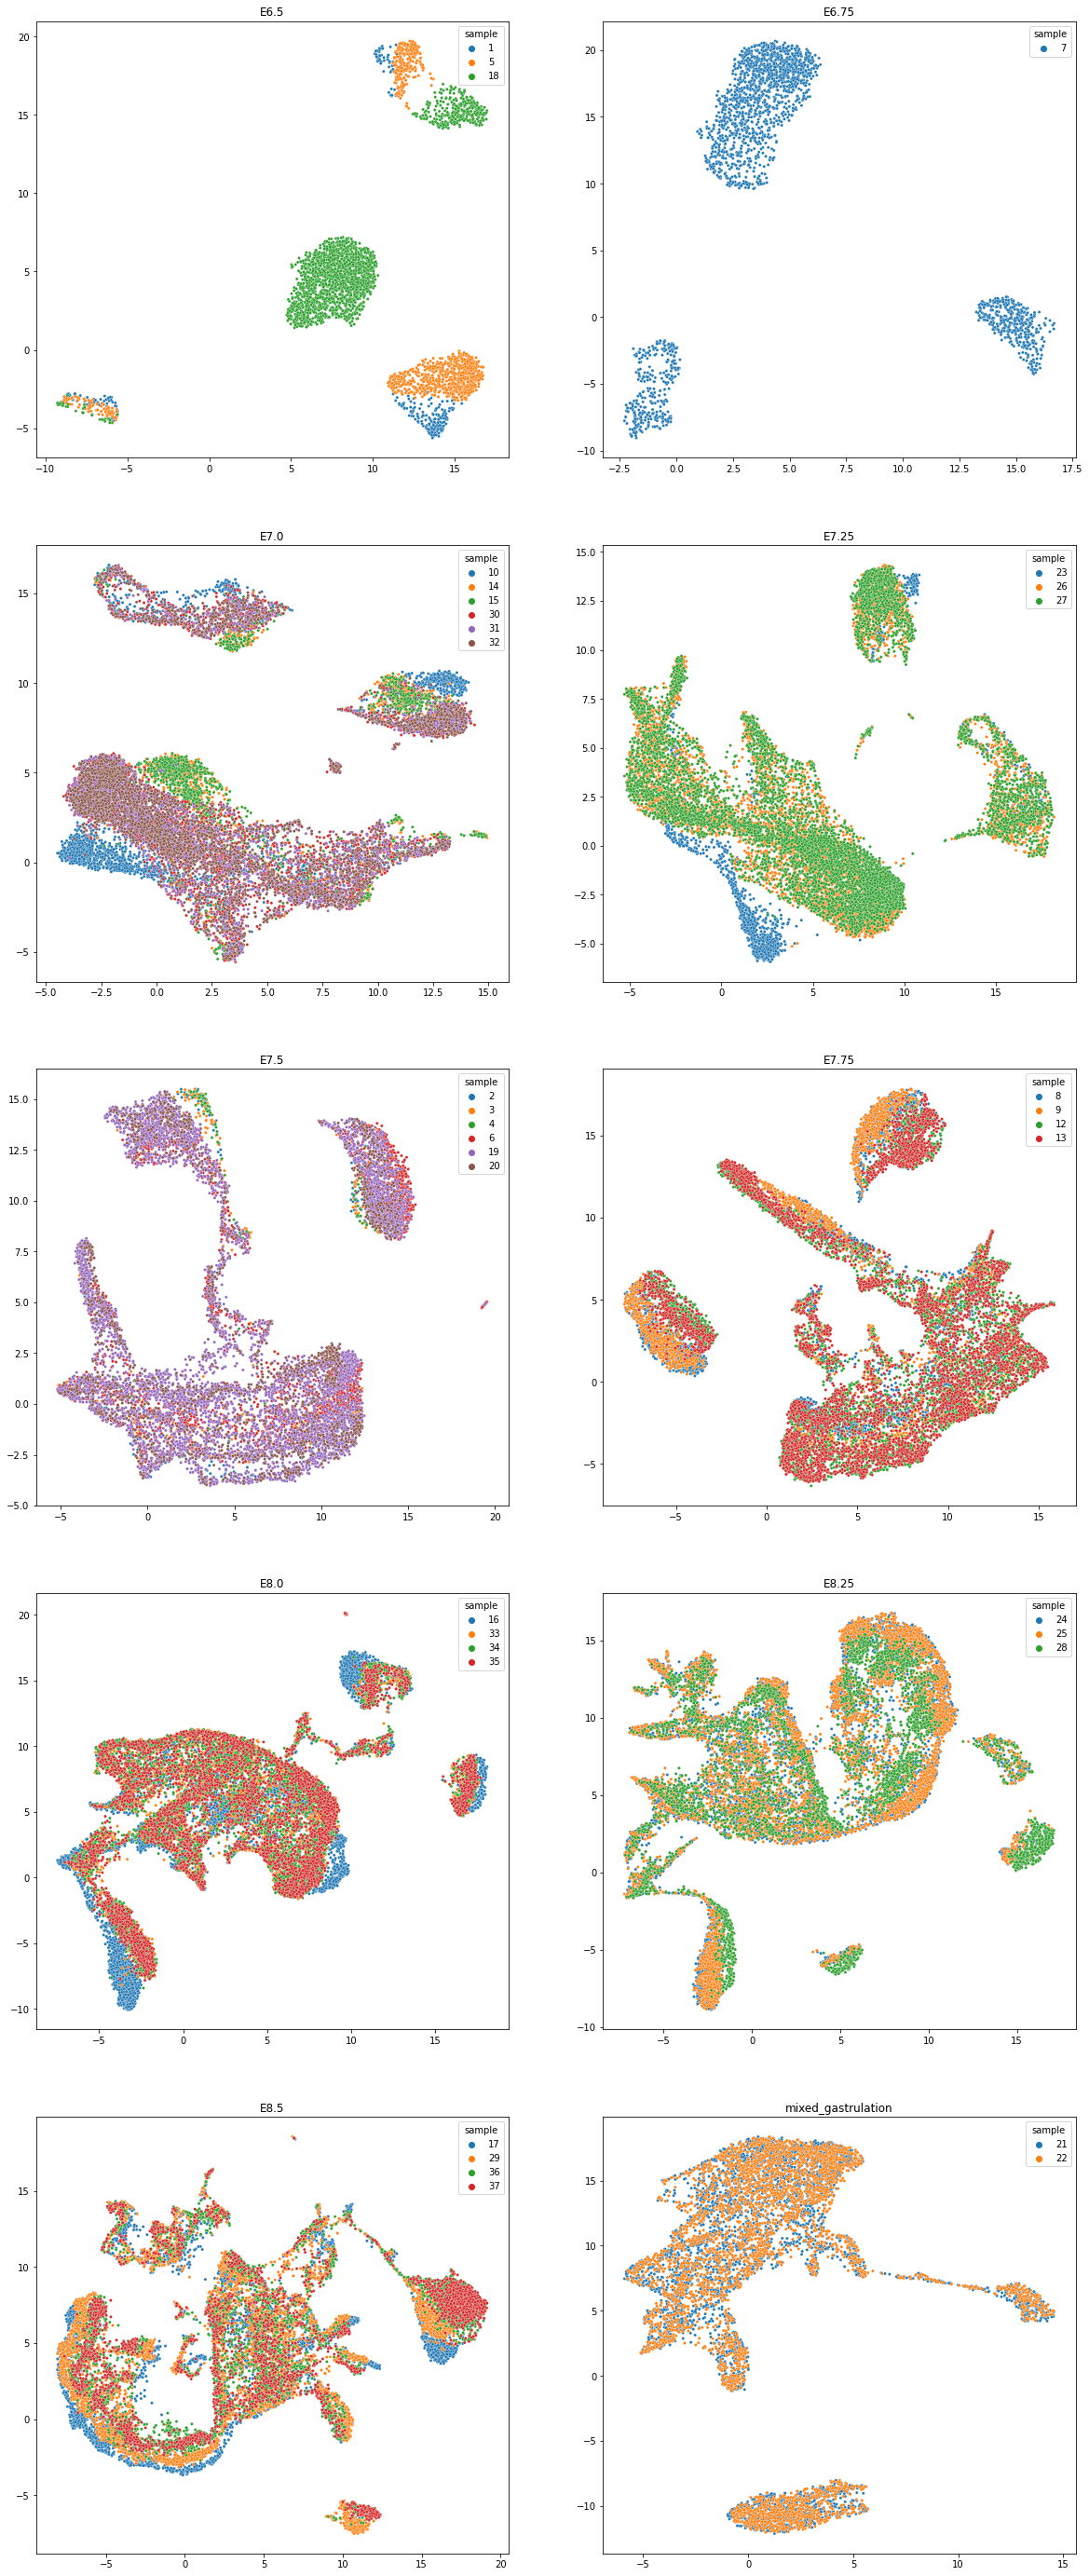

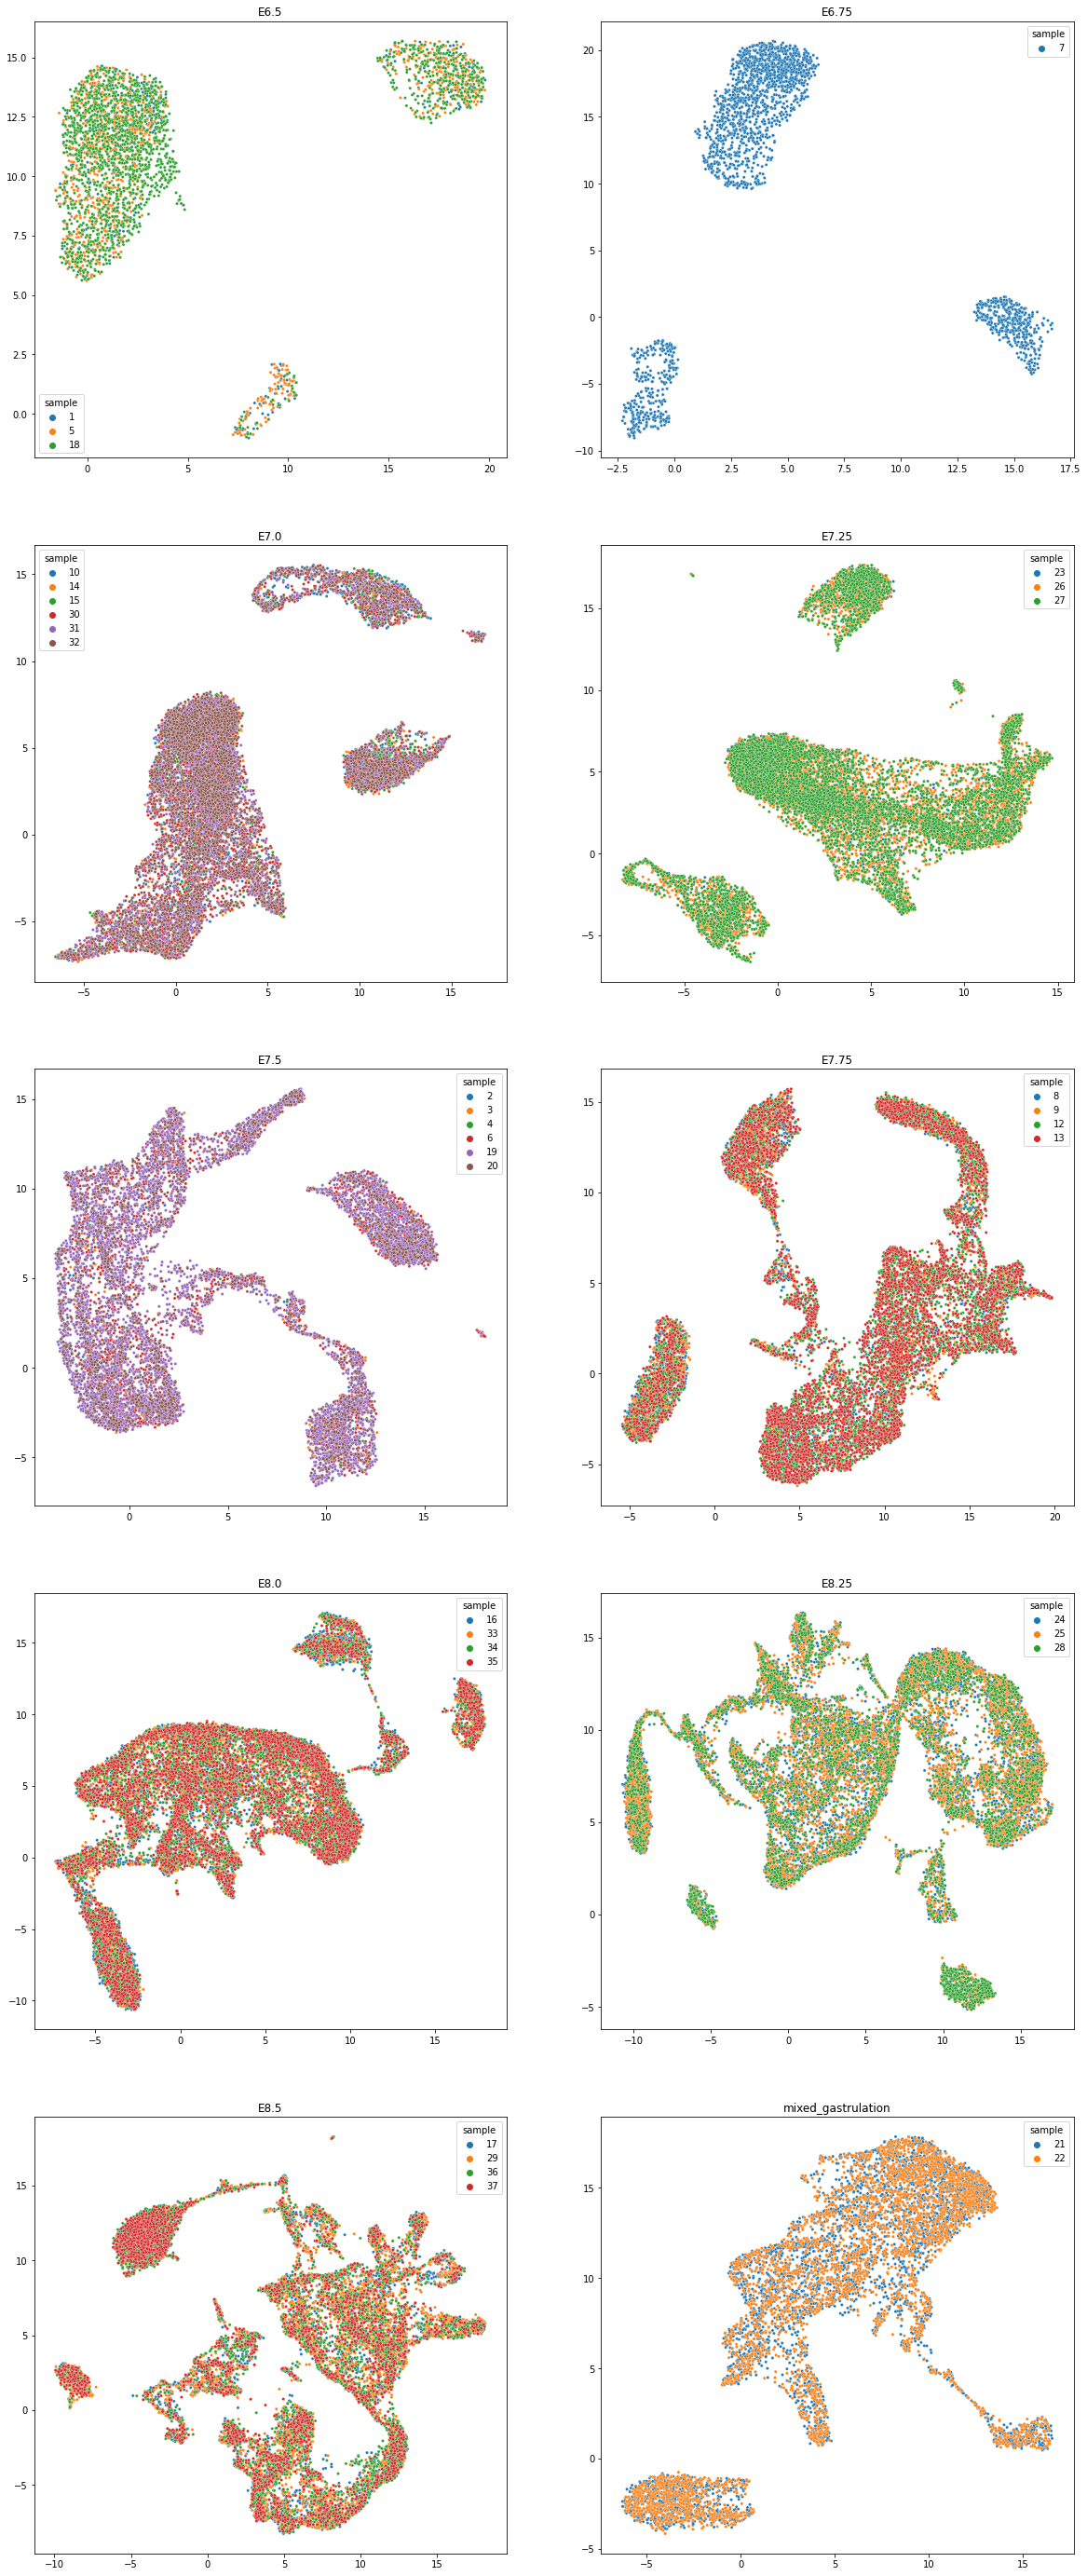

In [10]:
fig1,ax1 = plt.subplots(5,2,figsize=[20,50])
fig2,ax2 = plt.subplots(5,2,figsize=[20,50])
#fig3,ax3 = plt.subplots(5,2,figsize=[20,50])
for j,stage in enumerate(np.sort(a.obs["stage"].unique())):
    
    posx = j//2
    posy = j%2

    b = a[a.obs["stage"]==stage,:].copy()
    b.obs["stage"]=b.obs["stage"].astype(str)
    b.obs["sample"]=b.obs["sample"].astype(str)
    scp.pp.highly_variable_genes(b,flavor=HVG_METHOD)
    remove_highly_variable_genes(b,SKIP_GENES) #Remove genes related with sex or cell cycle
    
    #Raw
    scp.pp.pca(b,n_comps=N_PCS,use_highly_variable=USE_HVGs)
    scp.pp.neighbors(b,knn=N_NEIGBOURS,n_pcs=N_PCS)

    umap_seed_with_paga(b,LOUVAIN_INITIALISATION) #Not used because the random state is not properly working
    scp.tl.umap(b,init_pos="paga")
    
    sb.scatterplot(b.obsm["X_umap"][:,0],b.obsm["X_umap"][:,1],hue=b.obs["sample"],s=10,ax=ax1[posx,posy])
    ax1[posx,posy].set_title(stage)
    
    np.save("data/PCA_"+stage,b.obsm["X_pca"])
    np.save("data/UMAP_"+stage,b.obsm["X_umap"])
    
    #Harmony
    scp.external.pp.harmony_integrate(b,"sample")
    scp.pp.neighbors(b,knn=N_NEIGBOURS,n_pcs=N_PCS,use_rep="X_pca_harmony")

    umap_seed_with_paga(b,LOUVAIN_INITIALISATION) #Not used because the random state is not properly working
    scp.tl.umap(b,init_pos="paga")
    
    sb.scatterplot(b.obsm["X_umap"][:,0],b.obsm["X_umap"][:,1],hue=b.obs["sample"],s=10,ax=ax2[posx,posy])
    ax2[posx,posy].set_title(stage)

    np.save("data/PCA_harmony_"+stage,b.obsm["X_pca_harmony"])
    np.save("data/UMAP_harmony_"+stage,b.obsm["X_umap"])
    
    #MNN Some bug on the method and cannot be installed
    #fast_mnn_correct(b,"sample",k=N_NEIGBOURS)
    #scp.pp.neighbors(b,knn=N_NEIGBOURS,n_pcs=N_PCS,use_rep="X_pca_MNN")
    
    #umap_seed_with_paga(b,LOUVAIN_INITIALISATION)
    #scp.tl.umap(b,init_pos="paga")
    
    #sb.scatterplot(b.obsm["X_umap"][:,0],b.obsm["X_umap"][:,1],hue=b.obs["sample"],s=10,ax=ax3[posx,posy])
    #ax3[posx,posy].set_title(stage)

    #np.save("data/PCA_mnn"+stage+".png",b.obsm["X_pca_MNN"])
    #np.save("data/UMAP_mnn"+stage+".png",b.obsm["X_umap"])
    
fig1.savefig("Plots/4_Batch_Correction/Stages_without_correction_umap.png",bbox_inches="tight",transparent=True)
fig2.savefig("Plots/4_Batch_Correction/Stages_Harmony_umap.png",bbox_inches="tight",transparent=True)
#fig3.savefig("Plots/4_Batch_Correction/Stages_MNN_umap.png",bbox_inches="tight",transparent=True)